# TO DO: 
* Do temporal based outlier removal (Eye Data?)
* Check in Unity for the axes orientation (our z values are negative, which only makes sense if the z direction in the scene is inverted) 

In [265]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json
from itertools import compress
import math

from scipy import signal 

import glob

from DataManager import ParticipantData, MeasurementData
from Helpers import read_normalized_json_to_df, save_to_disk, load_from_disk, create_rolling_windows

def intersection(lst1, lst2): 
    tup1 = map(tuple, lst1) 
    tup2 = map(tuple, lst2)  
    return list(map(list, set(tup1).intersection(tup2))) 

def reject_outliers(data, m=2):
    # create index of data
    index = list(data.index)
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(data - np.mean(data)) < m * np.std(data)
    
    # apply to index and data and return
    return data[outlier_bool], list(compress(index, outlier_bool))

def anglebetween(v1, v2):
    v1Norm = v1/np.linalg.norm(v1)
    v2Norm = v2/np.linalg.norm(v2)
    Dot = np.dot(v1Norm, v2Norm)
    angle = math.degrees(np.arccos(Dot))
    
    return angle


def eye_outlier_removal(pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, m=1.5):
    
    # preparation
    outlier_df = pd.DataFrame()
    info_df = pd.DataFrame(columns=['Cluster', 'Length', 'Data Prop (%)'])
    pos_x = pos_x.copy()
    pos_y = pos_y.copy()
    pos_z = pos_z.copy()
    dir_x = dir_x.copy()
    dir_y = dir_y.copy()
    dir_z = dir_z.copy()
    
    # check where to remove outliers with 2 sigma distance
    outlier_bool = abs(pos_x - np.mean(pos_x)) > m * np.std(pos_x)
    # get outlier indices 
    outlier_df['outlier_index'] = pos_x[outlier_bool].index
    # check for sample clusters
    outlier_df['clusters'] = (outlier_df['outlier_index']-1 != outlier_df['outlier_index'].shift()).cumsum()

    for cluster in range(1, outlier_df.clusters.max()+1):

        min_c = np.min(outlier_df.outlier_index[outlier_df.clusters == cluster])
        max_c = np.max(outlier_df.outlier_index[outlier_df.clusters == cluster])
 
        # check the min edge case 
        if min_c == 0:
            pos_x[min_c:max_c+1] = (pos_x[min_c] + pos_x[max_c+2])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c] + pos_y[max_c+2])/2
            pos_z[min_c:max_c+1] = (pos_z[min_c] + pos_z[max_c+2])/2
            dir_x[min_c:max_c+1] = (dir_x[min_c] + dir_x[max_c+2])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c] + dir_y[max_c+2])/2
            dir_z[min_c:max_c+1] = (dir_z[min_c] + dir_z[max_c+2])/2
            
        # check the max edge case
        elif max_c == len(pos_x):
            pos_x[min_c:max_c+1] = (pos_x[min_c-1] + pos_x[max_c+1])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c-1] + pos_y[max_c+1])/2 
            pos_z[min_c:max_c+1] = (pos_z[min_c-1] + pos_z[max_c+1])/2 
            dir_x[min_c:max_c+1] = (dir_x[min_c-1] + dir_x[max_c+1])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c-1] + dir_y[max_c+1])/2 
            dir_z[min_c:max_c+1] = (dir_z[min_c-1] + dir_z[max_c+1])/2 
        # all other cases
        elif (max_c-min_c)<=21:
            pos_x[min_c:max_c+1] = (pos_x[min_c-1] + pos_x[max_c+2])/2
            pos_y[min_c:max_c+1] = (pos_y[min_c-1] + pos_y[max_c+2])/2
            pos_z[min_c:max_c+1] = (pos_z[min_c-1] + pos_z[max_c+2])/2
            dir_x[min_c:max_c+1] = (dir_x[min_c-1] + dir_x[max_c+2])/2
            dir_y[min_c:max_c+1] = (dir_y[min_c-1] + dir_y[max_c+2])/2
            dir_z[min_c:max_c+1] = (dir_z[min_c-1] + dir_z[max_c+2])/2

        else:
            pass
        
        info_df.loc[cluster, 'Cluster'] = cluster
        info_df.loc[cluster, 'Length'] = max_c - min_c
        info_df.loc[cluster, 'Data Prop (%)'] = (max_c - min_c)/len(pos_x)*100

    return pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info_df, outlier_df





Text(0.5, 1.0, 'dir_z')

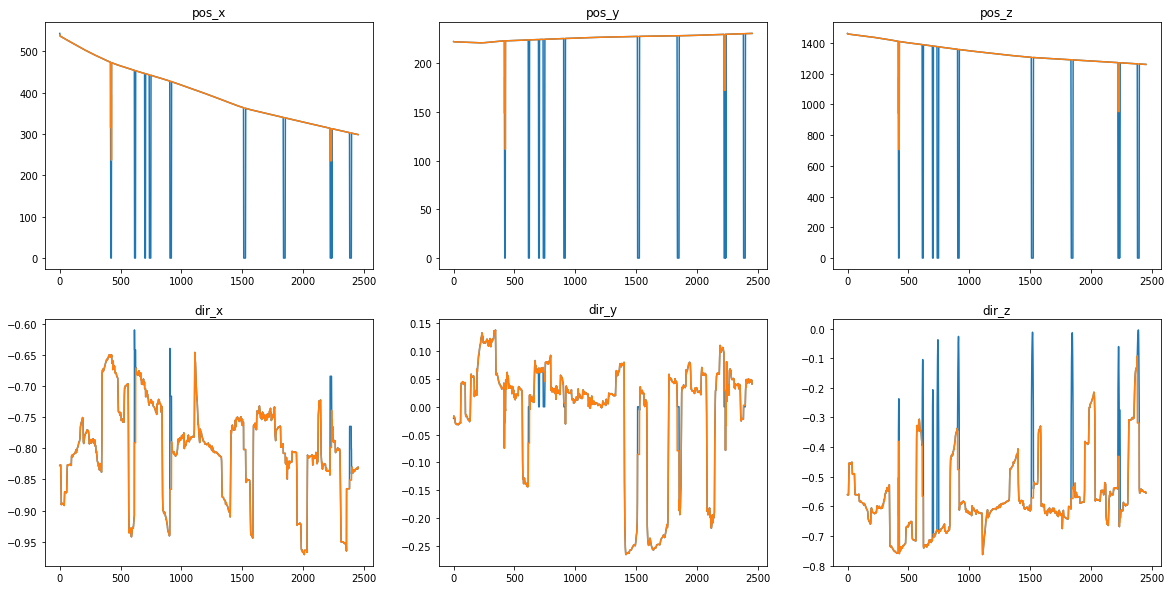

In [268]:
old_pos_x = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.x']
old_pos_y = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.y']
old_pos_z = one_participant_single_segment_no_ref_applied['EyePosWorldCombined.z']

old_dir_x = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x']
old_dir_y = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y']
old_dir_z = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z']

pos_x, pos_y, pos_z, dir_x, dir_y, dir_z, info, outliers = eye_outlier_removal(old_pos_x,
                                                                               old_pos_y,
                                                                               old_pos_z,
                                                                               old_dir_x,
                                                                               old_dir_y,
                                                                               old_dir_z)



plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(old_pos_x)
plt.plot(pos_x)
plt.title('pos_x')

plt.subplot(2,3,2)
plt.plot(old_pos_y)
plt.plot(pos_y)
plt.title('pos_y')

plt.subplot(2,3,3)
plt.plot(old_pos_z)
plt.plot(pos_z)
plt.title('pos_z')

plt.subplot(2,3,4)
plt.plot(old_dir_x)
plt.plot(dir_x)
plt.title('dir_x')

plt.subplot(2,3,5)
plt.plot(old_dir_y)
plt.plot(dir_y)
plt.title('dir_y')

plt.subplot(2,3,6)
plt.plot(old_dir_z)
plt.plot(dir_z)
plt.title('dir_z')

In [2]:
reference_data_all_failed_save_path = "./post_recorded_reference_data/reference_dict_all.pickle"
REFERENCE_DATA_ALL_EVENTS_FAILED = load_from_disk(reference_data_all_failed_save_path)

correlation_dict_path = "./post_recorded_reference_data/corr_dict.pickle"
CORRELATION_DICT = load_from_disk(correlation_dict_path)

# Load data

In [3]:
# global Location variable 
GLOBAL_AREA = 'Westbrueck' 
GLOBAL_SEGMENT = 0

In [4]:
eyes_paths  = ["./data/EyeTracking/"]
input_paths = ["./data/Input/"]
calib_paths = ["./data/ParticipantCalibrationData/"]
scene_paths = ["./data/SceneData/"]


measurement1 = MeasurementData(eyes_paths,input_paths,calib_paths,scene_paths,True)


MeasurementData: Found files for participant 0bc17d704fec4a9eb892d905fc2e5da9.
Input data files: ['./data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Autobahn.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_Westbrueck.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_TrainingScene.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_MountainRoad.txt', './data/Input/0bc17d704fec4a9eb892d905fc2e5da9_Input_CountryRoad.txt']
Eyetracking data files: ['./data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_MountainRoad.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Westbrueck.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_TrainingScene.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_Autobahn.txt', './data/EyeTracking/0bc17d704fec4a9eb892d905fc2e5da9_EyeTracking_CountryRoad.txt']
Calibration data files: ['./data/ParticipantCalibrationData/0bc17d704fec4a9eb892d905fc2e5da9_ParticipantCalib

In [5]:
measurement1.apply_reference_data(REFERENCE_DATA_ALL_EVENTS_FAILED)

MeasurementData: Applying reference data to all participants...
ParticipantData: Applying reference data to back of Westbrueck's segment 0. Number of datapoints used: 2089.
ParticipantData: Applying reference data to back of Westbrueck's segment 1. Number of datapoints used: 2131.
ParticipantData: Applying reference data to back of Westbrueck's segment 2. Number of datapoints used: 1932.
ParticipantData: Applying reference data to back of Westbrueck's segment 3. Number of datapoints used: 1767.
ParticipantData: Applying reference data to back of MountainRoad's segment 0. Number of datapoints used: 1691.
ParticipantData: Applying reference data to back of MountainRoad's segment 1. Number of datapoints used: 3131.
ParticipantData: Applying reference data to back of MountainRoad's segment 2. Number of datapoints used: 4347.
ParticipantData: Applying reference data to back of MountainRoad's segment 3. Number of datapoints used: 1036.
ParticipantData: Applying reference data to back of Coun

## Spectral density

In [112]:
# Extract data of one participant, of one area, of one segment 
print("Available participants: " + str(measurement1.get_participant_list()))
one_participant_single_segment = measurement1.get_data(use_vanilla=False, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment = one_participant_single_segment['0bc17d704fec4a9eb892d905fc2e5da9'][GLOBAL_AREA][GLOBAL_SEGMENT] 

# Average data over multiple sessions per segment
average_over_all_participants = measurement1.get_data(use_vanilla = False, filter_data=True, filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, exclude_participants=[])
average_over_all_participants = measurement1.average_data(average_over_all_participants)
average_over_all_participants_single_segment = average_over_all_participants[GLOBAL_AREA][GLOBAL_SEGMENT] 


Available participants: ['0bc17d704fec4a9eb892d905fc2e5da9', '0d0d7bd79b1a48d4ad5e757cdbfc15c9']
ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobah

/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


# Comparing vanilla & reference data applied & reference data

In [9]:
# Extract data of one participant, of one area, of one segment without ref data applied 
one_participant_single_segment_no_ref_applied = measurement1.get_data(use_vanilla=True, filter_data=True, \
                 filter_by_corr_coeff_dict=CORRELATION_DICT, corr_coeff_threshold=0.95, \
                 exclude_participants=['0d0d7bd79b1a48d4ad5e757cdbfc15c9'])
one_participant_single_segment_no_ref_applied = \
    one_participant_single_segment_no_ref_applied['0bc17d704fec4a9eb892d905fc2e5da9'][GLOBAL_AREA][GLOBAL_SEGMENT]

ref_data_one_participant_single_segment = REFERENCE_DATA_ALL_EVENTS_FAILED[GLOBAL_AREA][GLOBAL_SEGMENT]  



ParticipantData: Filtering data by Correlation Coefficients with threshold 0.95.
ParticipantData: Corr-coeff filtering excluded Westbrueck segment 2 with min corr-coeffs 0.9055197317583018.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 1 with min corr-coeffs 0.9440682544132852.
ParticipantData: Corr-coeff filtering excluded MountainRoad segment 2 with min corr-coeffs 0.4288595845461723.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 1 with min corr-coeffs 0.9378459305925257.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 2 with min corr-coeffs 0.8192290224652639.
ParticipantData: Corr-coeff filtering excluded CountryRoad segment 3 with min corr-coeffs 0.9363527740836213.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 1 with min corr-coeffs 0.6856464347733652.
ParticipantData: Corr-coeff filtering excluded Autobahn segment 3 with min corr-coeffs -0.9139574552395952.


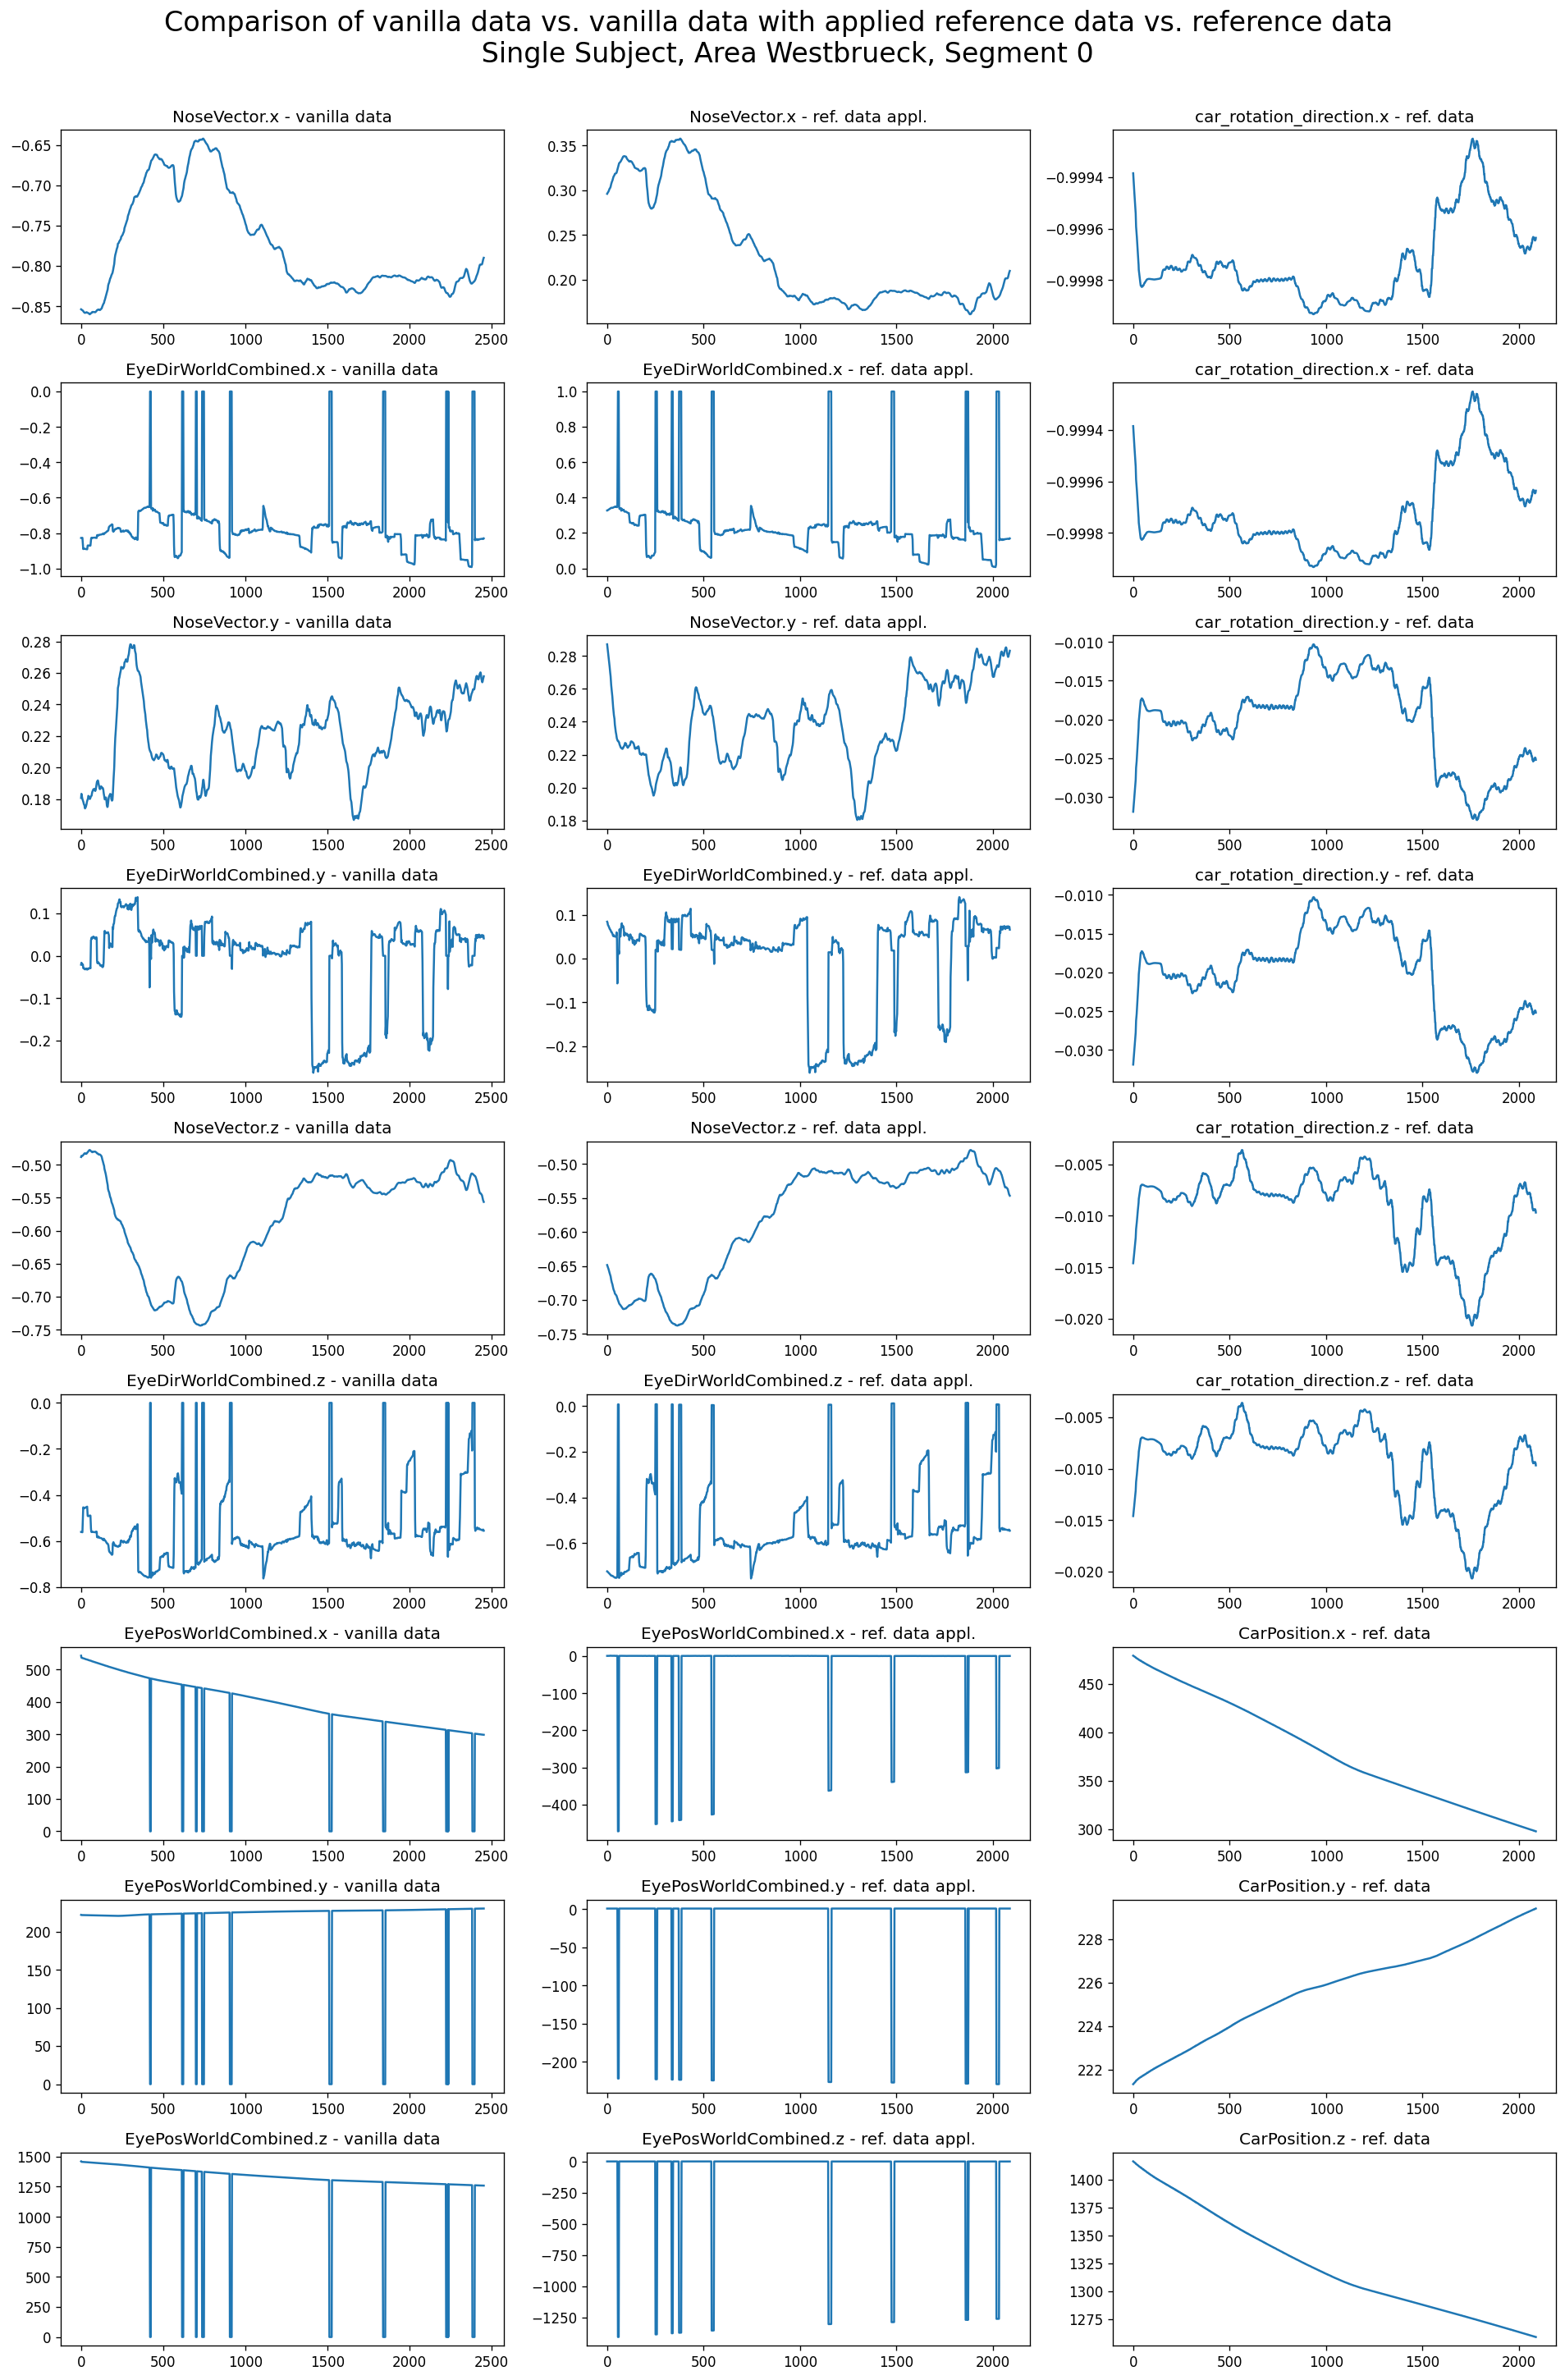

In [10]:
# plot comparison 

fig, ax = plt.subplots(nrows=9, ncols=3, figsize=(16,24), dpi=120)

names_x = ["NoseVector.x","NoseVector.x",'car_rotation_direction.x',"EyeDirWorldCombined.x","EyeDirWorldCombined.x",'car_rotation_direction.x', \
           "NoseVector.y","NoseVector.y",'car_rotation_direction.y',"EyeDirWorldCombined.y","EyeDirWorldCombined.y",'car_rotation_direction.y', \
           "NoseVector.z","NoseVector.z",'car_rotation_direction.z',"EyeDirWorldCombined.z","EyeDirWorldCombined.z",'car_rotation_direction.z', \
           'EyePosWorldCombined.x','EyePosWorldCombined.x','CarPosition.x', \
           'EyePosWorldCombined.y','EyePosWorldCombined.y','CarPosition.y', \
           'EyePosWorldCombined.z','EyePosWorldCombined.z','CarPosition.z'
          ]




for idx, row in enumerate(ax.reshape(-1)):
    
    if idx % 3 == 0:
        
        x = one_participant_single_segment_no_ref_applied[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - vanilla data")
        
    elif idx % 3 == 1:
        
        x = one_participant_single_segment[names_x[idx]]
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data appl.")
    
    elif idx % 3 == 2:
        
        x = ref_data_one_participant_single_segment[names_x[idx]] 
        row.plot(x)
        row.set_title(names_x[idx] + " - ref. data")


fig.suptitle("Comparison of vanilla data vs. vanilla data with applied reference data vs. reference data \n Single Subject, Area " + GLOBAL_AREA + ", Segment " + str(GLOBAL_SEGMENT),fontsize=20, y=1.005)
    
fig.tight_layout() 
plt.show()

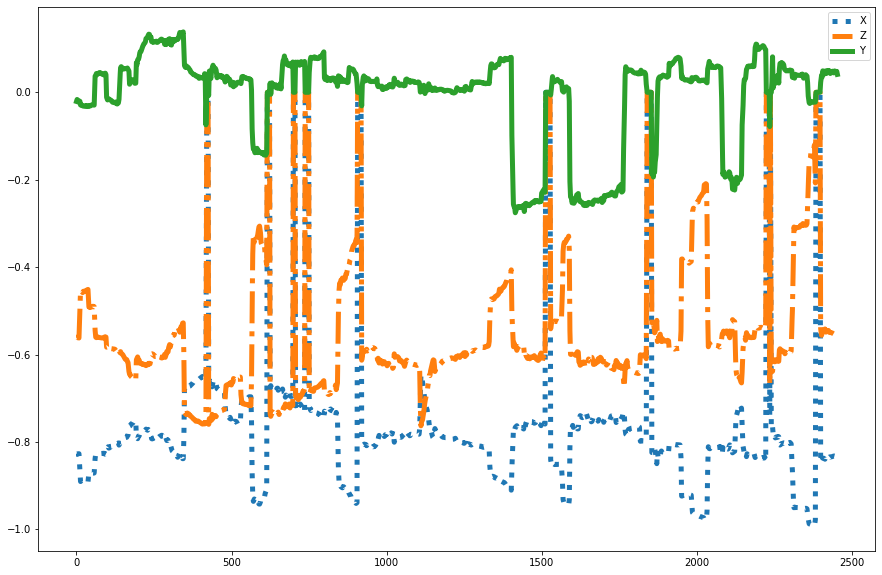

In [22]:
plt.figure(figsize=(15,10))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'], linewidth=5, linestyle=':')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z'], linewidth=5, linestyle='-.')
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y'], linewidth=5)

plt.legend(['X', 'Z', 'Y'])

<ipython-input-27-081a143d2965>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = (data[i+1] + data[i-1])/2
<ipython-input-27-081a143d2965>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = (data[i+1] + data[i-1])/2
<ipython-input-27-081a143d2965>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = (data[i+1] + data[i-1])/2


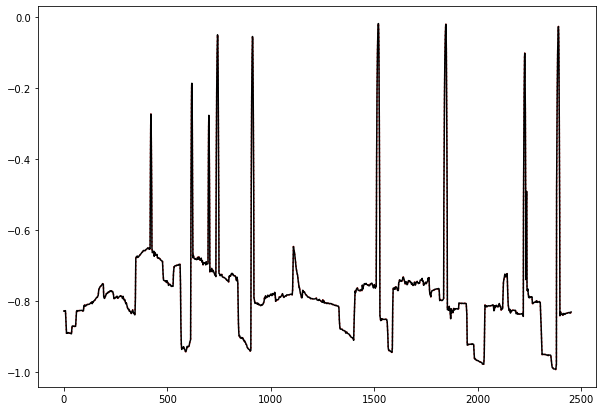

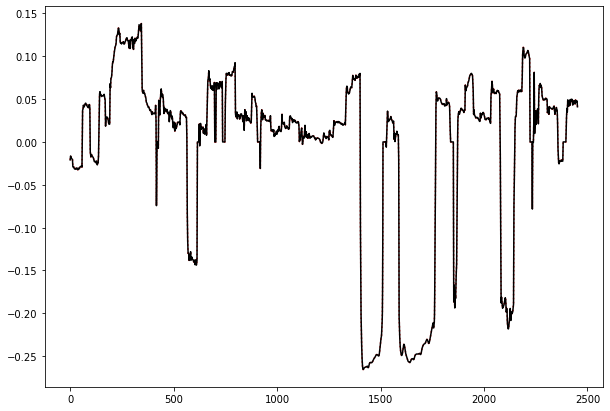

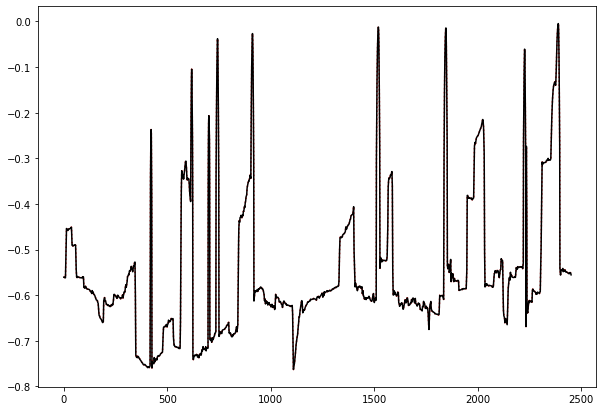

In [32]:
clean_eyeX = interpolate_outliers(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'])
clean_eyeY = interpolate_outliers(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y'])
clean_eyeZ = interpolate_outliers(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z'])

plt.figure(figsize=(10,7))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'],linestyle=':', color='r')
plt.plot(clean_eyeX, color='k')
plt.figure(figsize=(10,7))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.y'],linestyle=':', color='r')
plt.plot(clean_eyeY, color='k')
plt.figure(figsize=(10,7))
plt.plot(one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.z'],linestyle=':', color='r')
plt.plot(clean_eyeZ, color='k')

In [37]:
data = one_participant_single_segment_no_ref_applied['EyeDirWorldCombined.x'].copy()
m = 2

outlier_bool = abs(data - np.mean(data)) > m * np.std(data)
# get outlier indices 
outlier_index = data[outlier_bool].index
# check whether it is a one sample outlier 
for i in outlier_index:
    # check boundary conditions
    if i == 0:
        data[i] = data[i+1]

    elif i == len(data):
        data[i] = data[i-1]

    else:
        data[i] = (data[i+1] + data[i-1])/2

outlier_index

Int64Index([ 419,  420,  421,  422,  423,  424,  615,  616,  617,  618,  619,
             620,  621,  622,  699,  700,  701,  702,  703,  704,  737,  738,
             739,  740,  741,  742,  743,  744,  745,  746,  747,  748,  906,
             907,  908,  909,  910,  911,  912,  913,  914,  915,  916,  917,
            1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522,
            1523, 1524, 1525, 1526, 1838, 1839, 1840, 1841, 1842, 1843, 1844,
            1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 2223, 2224, 2225,
            2226, 2227, 2228, 2229, 2230, 2231, 2232, 2237, 2382, 2383, 2384,
            2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395,
            2396],
           dtype='int64')

# Power Spectral Density on raw data (ref. data applied)

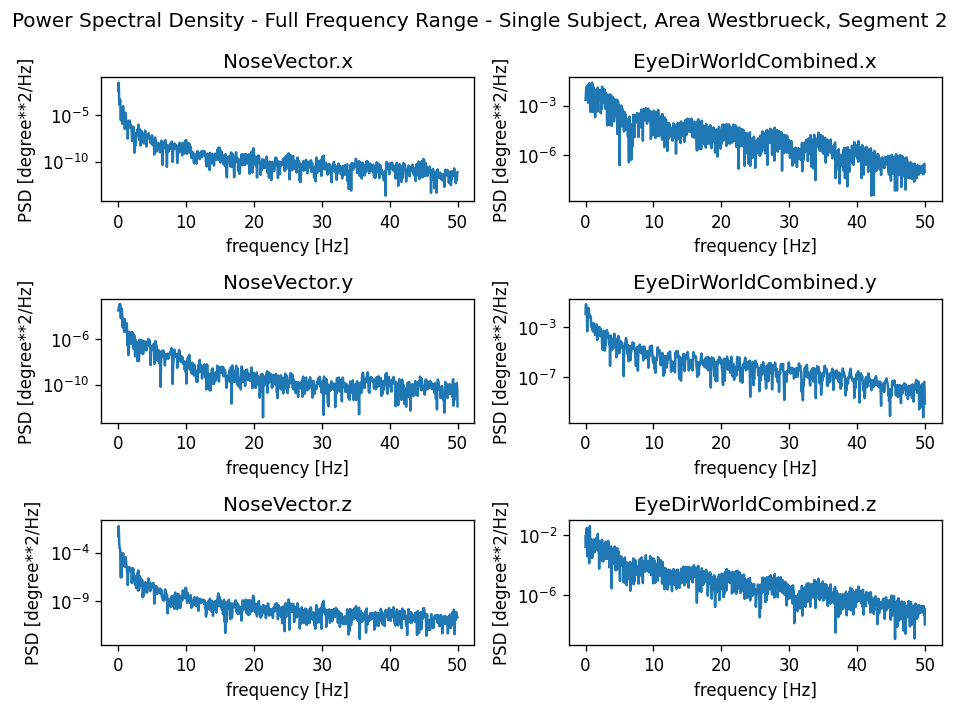

In [13]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 100])
    #row.set_xlim([0, 2])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

# Checking for data similarity (Nose to Eye)
* X - Sanity:
    * always positive, i.e. subjects look towards the right
    * Makes sense since subjects sit on left car seat and look at central information aways from steering wheel
* Y - Sanity:
    * NoseY is always positive, i.e. head slightly raised, but eyes are level 
    * Could be VR effect due to the HMD weight
* Z - Sanity:
    * Always negative
    * Hypothesis: Car drives in negative z direction in the scene 

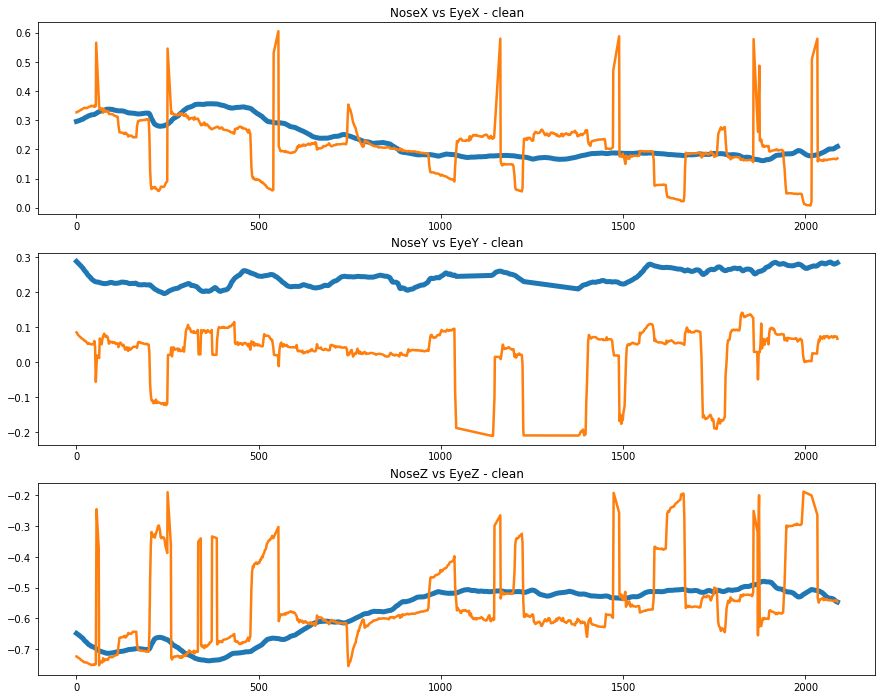

In [19]:
# X
NoseX = one_participant_single_segment['NoseVector.x'] 
EyeX = one_participant_single_segment['EyeDirWorldCombined.x'] 
X_index_intersection = list(set(noseXindex).intersection(eyeXindex))

# Y
NoseY = one_participant_single_segment['NoseVector.y']
EyeY = one_participant_single_segment['EyeDirWorldCombined.y']
Y_index_intersection = list(set(noseYindex).intersection(eyeYindex))

# Z
NoseZ = one_participant_single_segment['NoseVector.z']
EyeZ = one_participant_single_segment['EyeDirWorldCombined.z']
Z_index_intersection = list(set(noseZindex).intersection(eyeZindex))

# Plot 
plt.figure(figsize=(15,12))
plt.subplot(3,1,1)
plt.title('NoseX vs EyeX - clean')
plt.plot(NoseX[X_index_intersection], linewidth=5)
plt.plot(EyeX[X_index_intersection], linewidth=2.5)

plt.subplot(3,1,2)
plt.title('NoseY vs EyeY - clean')
plt.plot(NoseY[Y_index_intersection], linewidth=5)
plt.plot(EyeY[Y_index_intersection], linewidth=2.5)

plt.subplot(3,1,3)
plt.title('NoseZ vs EyeZ - clean')
plt.plot(NoseZ[Z_index_intersection], linewidth=5)
plt.plot(EyeZ[Z_index_intersection], linewidth=2.5)

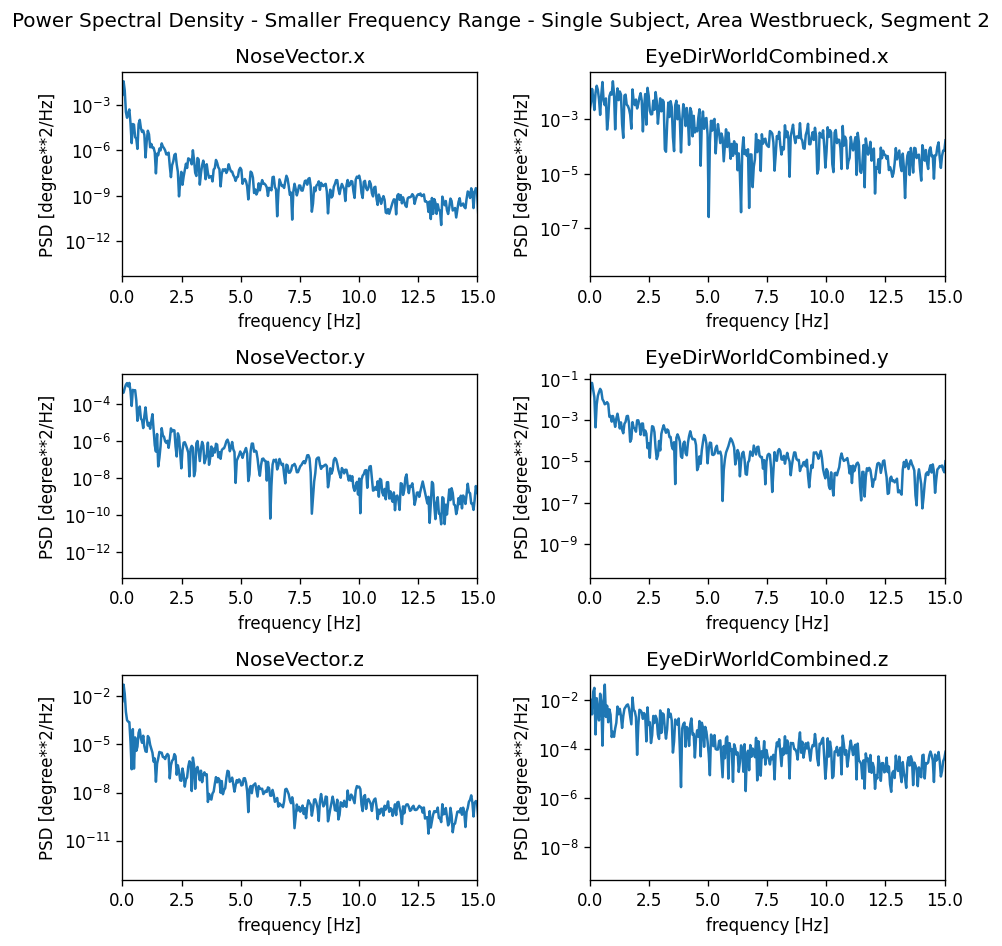

In [29]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = one_participant_single_segment[names_x[idx]]
    
    
    f, pxx_den = signal.welch(x=x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,15)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

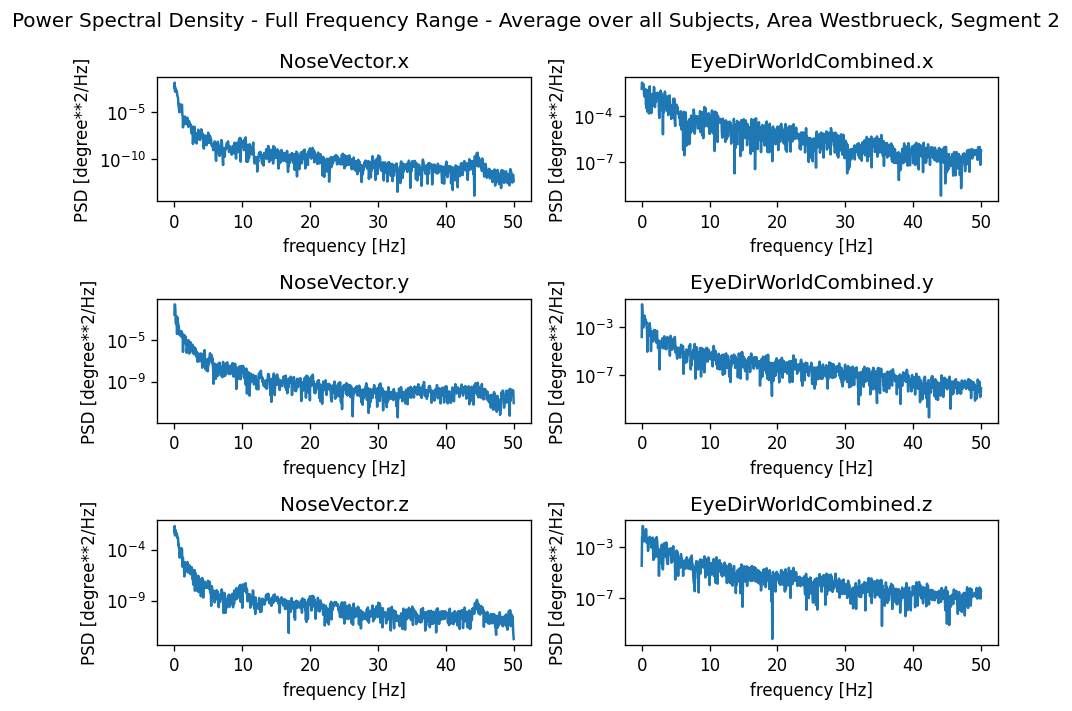

In [30]:
# power spectral density using welch's method, full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    x = average_over_all_participants_single_segment[names_x[idx]]
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

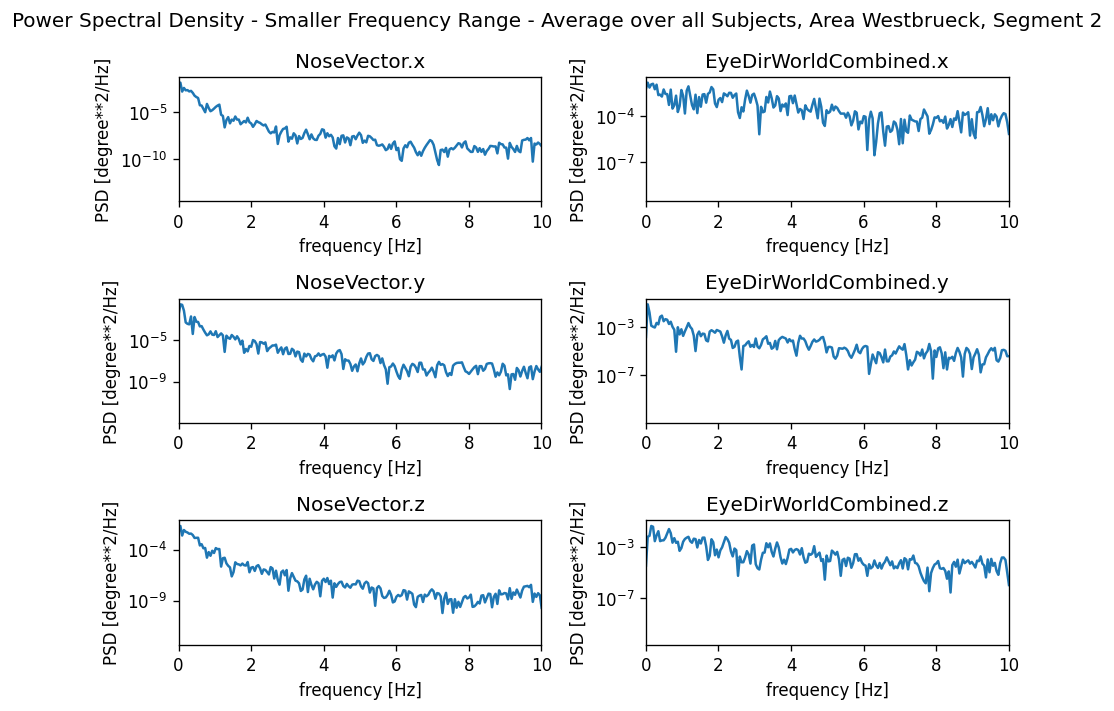

In [31]:
# power spectral density using welch's method, smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,6), dpi=120)

names_x = ["NoseVector.x","EyeDirWorldCombined.x","NoseVector.y","EyeDirWorldCombined.y","NoseVector.z","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
    
    x = average_over_all_participants_single_segment[names_x[idx]]
    
    f, pxx_den = signal.welch(x,fs=(1/0.01),nperseg=2048)
    row.semilogy(f, pxx_den)
    #row.set_ylim([0.5e-3, 1])
    row.set_xlabel('frequency [Hz]')
    row.set_ylabel('PSD [degree**2/Hz]')
    row.set_xlim(0,10)
    row.set_title(names_x[idx])

fig.suptitle("Power Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()
plt.show()

## Cross spectral density

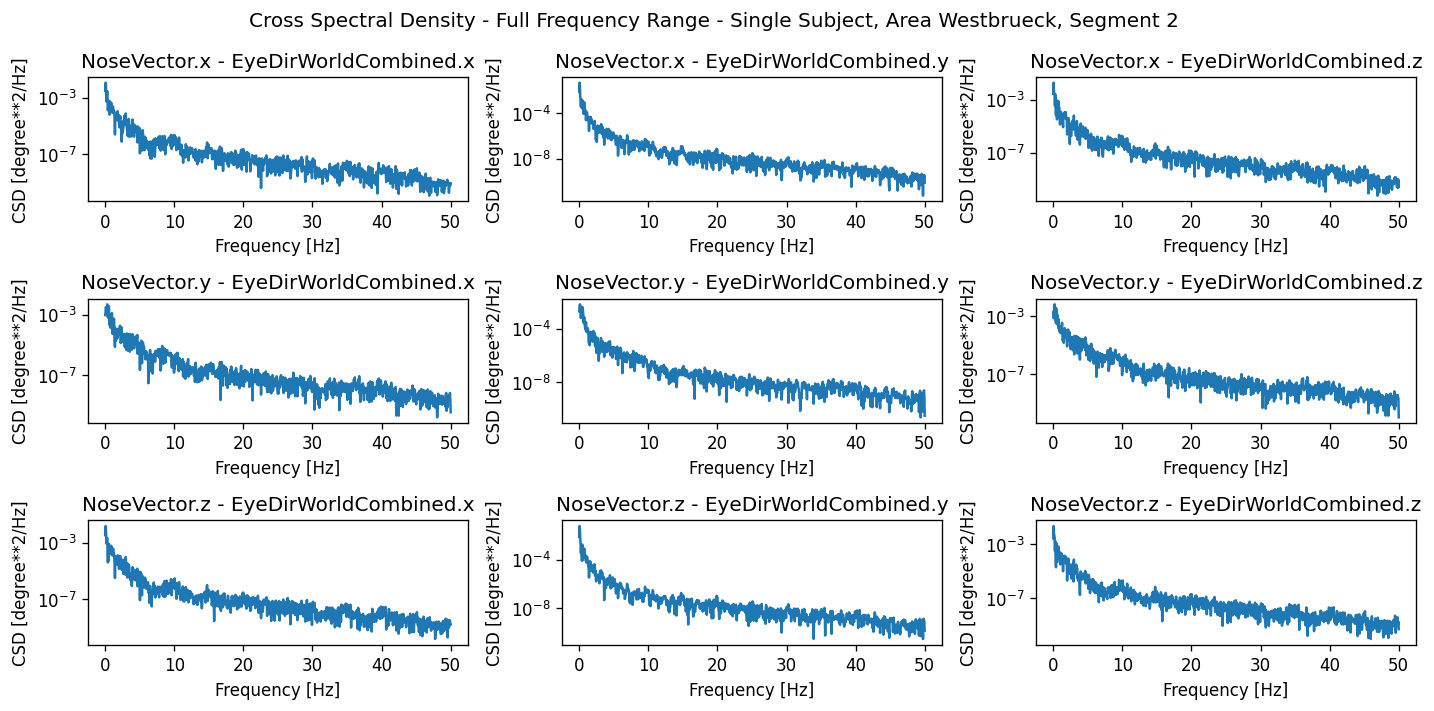

In [33]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = one_participant_single_segment[names_x[idx]]
        y = one_participant_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1969, using nperseg = 1969
  warnings.warn('nperseg = {0:d} is greater than input length '
/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1969, using nperseg = 1969
  warnings.warn('nperseg = {0:d} is greater than input length '
/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1969, using nperseg = 1969
  warnings.warn('nperseg = {0:d} is greater than input length '
/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 2048 is greater than input length  = 1969, using nperseg = 1969
  warnings.warn('nperseg = {0:d} is greater than input length '
/Applica

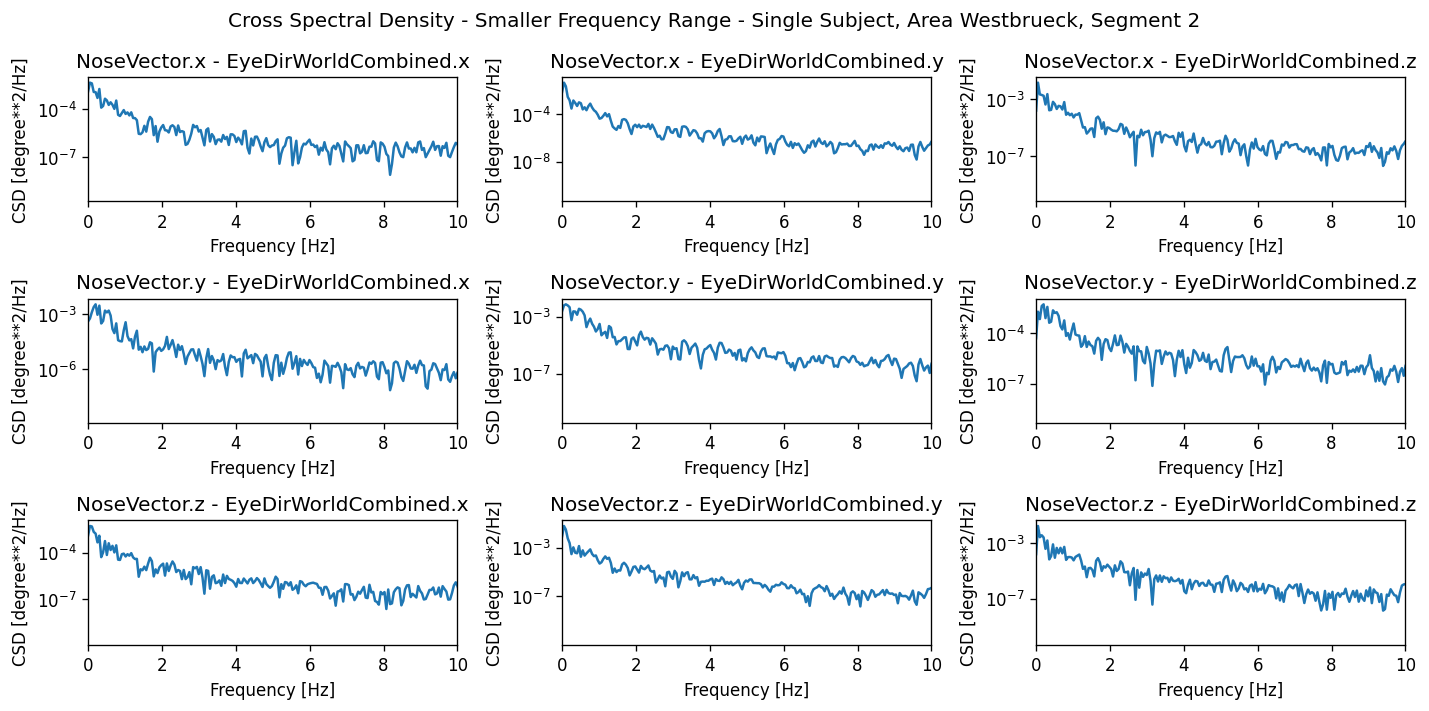

In [34]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = one_participant_single_segment[names_x[idx]]
        y = one_participant_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x[index_intersection],y[index_intersection],fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Single Subject, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

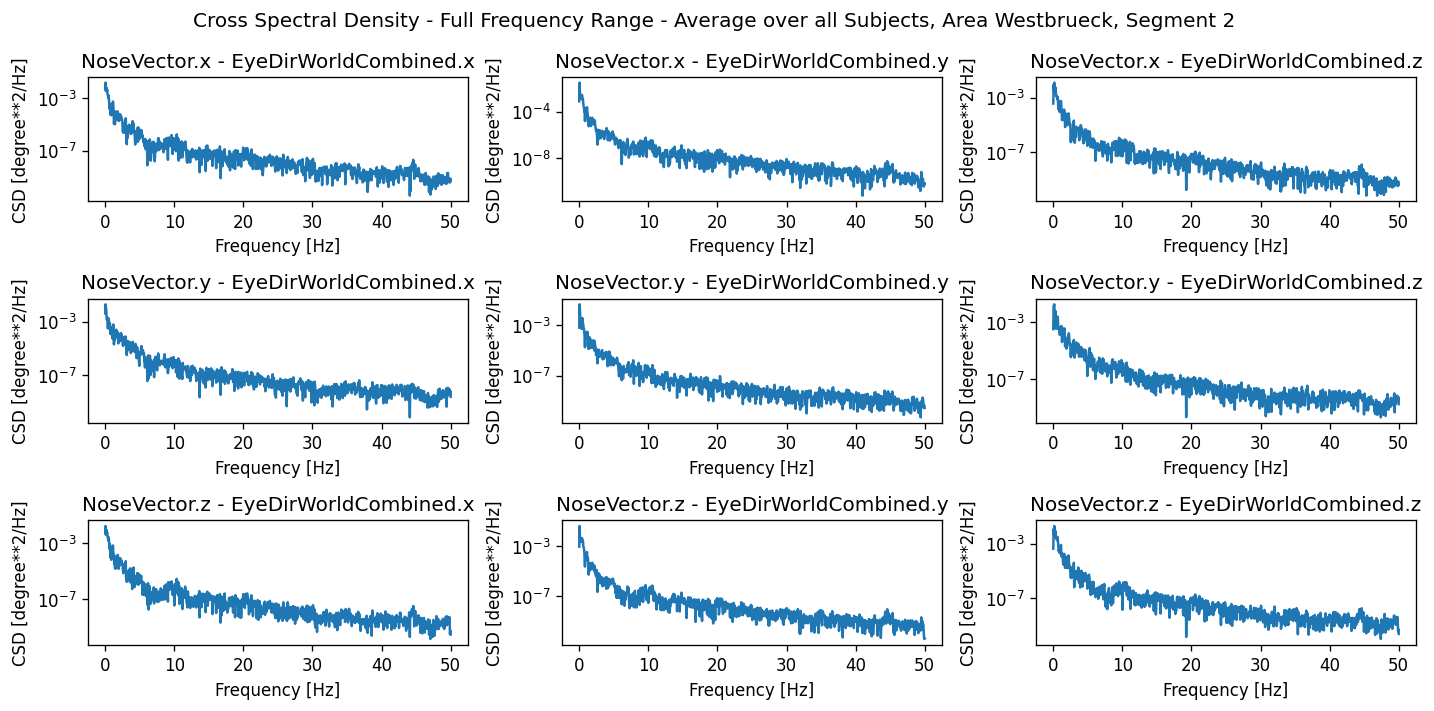

In [35]:
# csd full frequency range 

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):
        x = average_over_all_participants_single_segment[names_x[idx]]
        y = average_over_all_participants_single_segment[names_y[idx]]
        
        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Full Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()

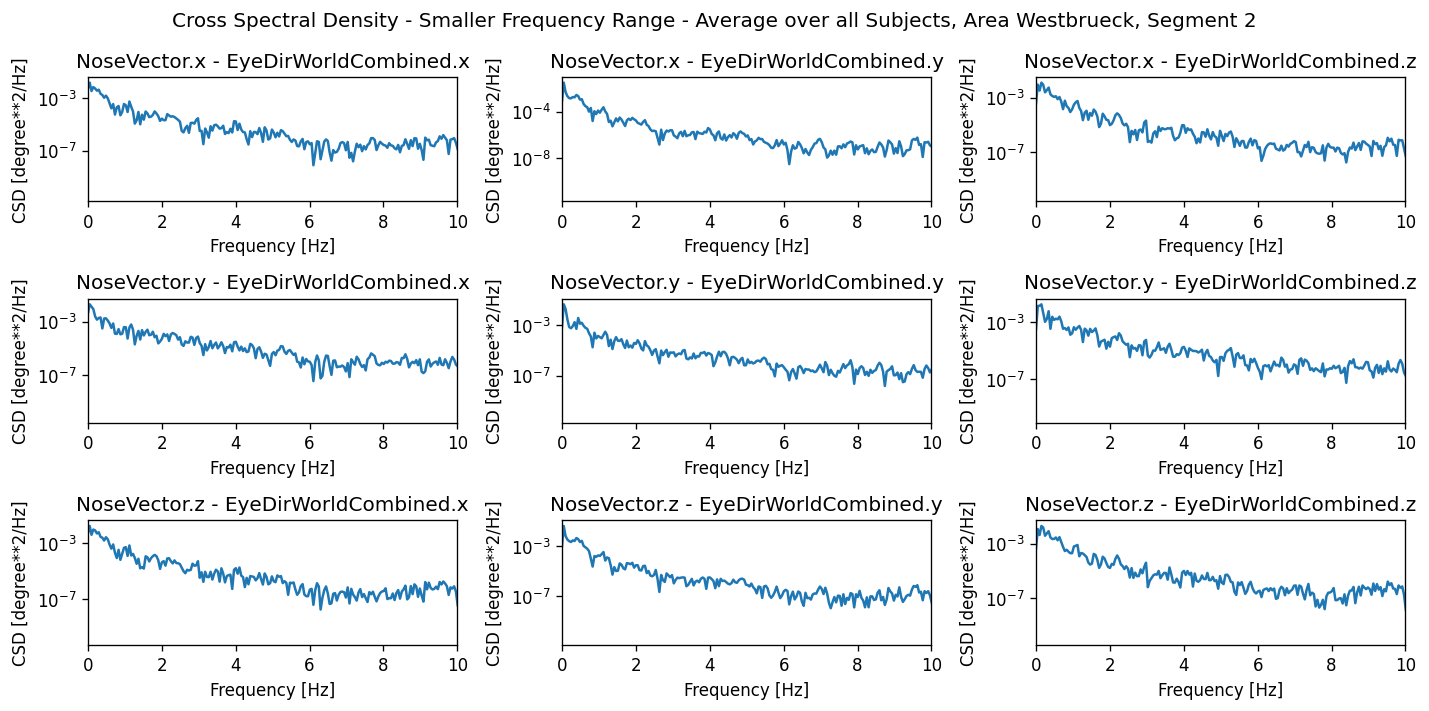

In [36]:
# csd smaller frequency range

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,6), dpi=120)

names_x = ["NoseVector.x","NoseVector.x","NoseVector.x","NoseVector.y","NoseVector.y","NoseVector.y","NoseVector.z","NoseVector.z","NoseVector.z"]
names_y = ["EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z","EyeDirWorldCombined.x","EyeDirWorldCombined.y","EyeDirWorldCombined.z"]

for idx, row in enumerate(ax.reshape(-1)):

        x = average_over_all_participants_single_segment[names_x[idx]]
        y = average_over_all_participants_single_segment[names_y[idx]]

        sample_freqs, csd = signal.csd(x,y,fs=(1/0.01),nperseg=2048)
        row.semilogy(sample_freqs, np.abs(csd))
        row.set_xlabel("Frequency [Hz]")
        row.set_ylabel("CSD [degree**2/Hz]")
        row.set_xlim(0,10)
        row.set_title(names_x[idx] + " - " + names_y[idx])

fig.suptitle("Cross Spectral Density - Smaller Frequency Range - Average over all Subjects, Area Westbrueck, Segment 2")
fig.tight_layout()

plt.show()